Model loaded successfully.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step
Overall Prediction: 0.9117301106452942


2024-05-18 10:59:36.959 Python[4764:70372] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


Number of red circles detected: 10


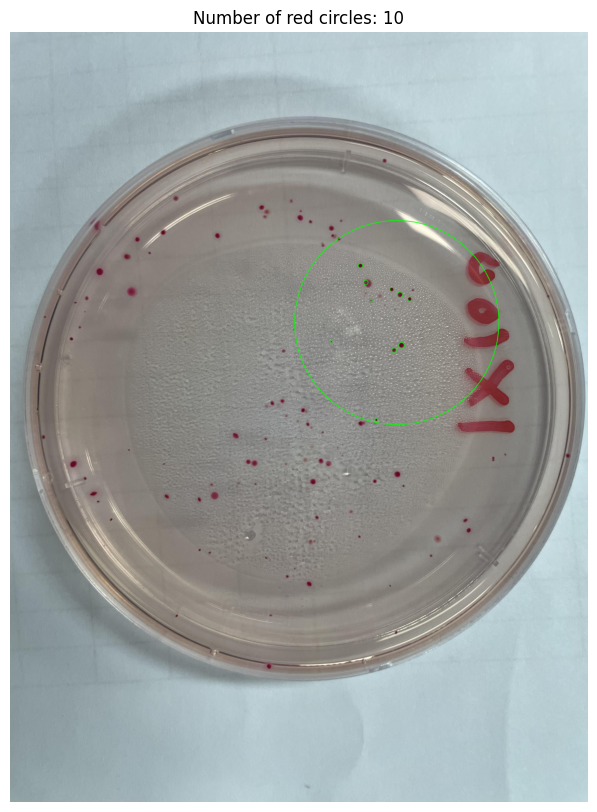

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 학습된 모델 로드
model = load_model('/Users/lol/Documents/GitHub/model/colony_detector_model.h5')
print("Model loaded successfully.")

# 이미지 경로
image_path = '/Users/lol/Documents/GitHub/Python/image/red_colony.jpg'

# 이미지 전처리 및 분할 함수
def preprocess_and_split_image(image_path, tile_size=(256, 256)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at path '{image_path}' could not be loaded. Please check the file path.")
    
    h, w, _ = image.shape
    tiles = []
    
    # 이미지를 tile_size 크기로 분할
    for y in range(0, h, tile_size[1]):
        for x in range(0, w, tile_size[0]):
            tile = image[y:y+tile_size[1], x:x+tile_size[0]]
            if tile.shape[0] != tile_size[1] or tile.shape[1] != tile_size[0]:
                # 패딩을 추가하여 크기를 맞춤
                tile = cv2.copyMakeBorder(tile, 0, tile_size[1] - tile.shape[0], 0, tile_size[0] - tile.shape[1], cv2.BORDER_CONSTANT, value=(0, 0, 0))
            tile_scaled = tile / 255.0
            tiles.append(tile_scaled)
    
    tiles = np.array(tiles)
    grid_shape = (len(range(0, h, tile_size[1])), len(range(0, w, tile_size[0])))
    return tiles, grid_shape, h, w  # h와 w를 반환하여 원본 크기를 유지

# 예측 수행 함수
def predict_colony(image_path, model):
    tiles, grid_shape, h, w = preprocess_and_split_image(image_path)
    predictions = model.predict(tiles)
    return predictions, grid_shape, h, w

# 붉은색 동그라미 콜로니를 카운트하는 함수
def count_red_circles(image, circle):
    original_image = image.copy()

    # 이미지에서 원 영역 자르기
    mask = np.zeros_like(image[:, :, 0])
    cv2.circle(mask, (circle[0], circle[1]), circle[2], 255, -1)
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    
    # 이미지를 HSV 색 공간으로 변환
    hsv = cv2.cvtColor(masked_image, cv2.COLOR_BGR2HSV)

    # 붉은색의 범위를 정의 (연한 붉은색 ~ 진한 붉은색)
    lower_red1 = np.array([0, 50, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 50, 50])
    upper_red2 = np.array([180, 255, 255])

    # 붉은색에 해당하는 마스크 생성
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = mask1 | mask2

    # 마스크에 블러 적용
    blurred = cv2.GaussianBlur(mask, (5, 5), 2)

    # 동그라미 검출
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.4, minDist=10,
                               param1=60, param2=22, minRadius=2, maxRadius=50)

    # 동그라미 카운트 및 이미지에 표시
    circle_count = 0
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            if 4 < r < 20:  # 필터링 조건 추가
                cv2.circle(original_image, (x, y), r, (0, 255, 0), 2)  # 원본 이미지에 동그라미 표시
                circle_count += 1

    return circle_count, original_image

# 마우스 이벤트를 처리하는 함수
def draw_circle(event, x, y, flags, param):
    global ix, iy, drawing, image

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix, iy = x, y

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            image = temp_image.copy()
            cv2.circle(image, (ix, iy), int(((x - ix)**2 + (y - iy)**2)**0.5), (0, 255, 0), 2)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        radius = int(((x - ix)**2 + (y - iy)**2)**0.5)
        cv2.circle(image, (ix, iy), radius, (0, 255, 0), 2)
        circle_count, output_image = count_red_circles(image, (ix, iy, radius))
        print(f"Number of red circles detected: {circle_count}")

        # 결과 이미지 시각화
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Number of red circles: {circle_count}")
        plt.axis('off')
        plt.show()
        
        # 창 닫기 시도
        cv2.destroyAllWindows()
        for i in range(1, 5):
            cv2.waitKey(1)

# 모델을 사용하여 예측 수행
predictions, grid_shape, h, w = predict_colony(image_path, model)

# 예측 결과를 2D 배열로 재구성
predictions_2d = predictions.reshape(grid_shape)

# 전체 이미지에서 예측된 부분을 결합하여 하나의 결과로 통합
overall_prediction = np.mean(predictions_2d)

print(f"Overall Prediction: {overall_prediction}")

# 예측 결과에 따라 붉은색 동그라미 콜로니 카운트 수행
if overall_prediction > 0.6:  # 임계값을 0.6로 설정하여 콜로니가 있는지 확인
    image = cv2.imread(image_path)
    temp_image = image.copy()
    drawing = False  # 마우스 드래그 상태 플래그
    ix, iy = -1, -1  # 마우스 클릭 좌표 초기화

    cv2.namedWindow('image')
    cv2.setMouseCallback('image', draw_circle)

    while True:
        cv2.imshow('image', image)
        if cv2.waitKey(20) & 0xFF == 27:  # Esc 키를 누르면 종료
            break

    cv2.destroyAllWindows()
    for i in range(1, 5):
        cv2.waitKey(1)
else:
    print("No colonies detected in the image.")

/Users/lol/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/lol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model loaded successfully.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step
Overall Prediction: 0.9117301106452942
Number of red circles detected: 96


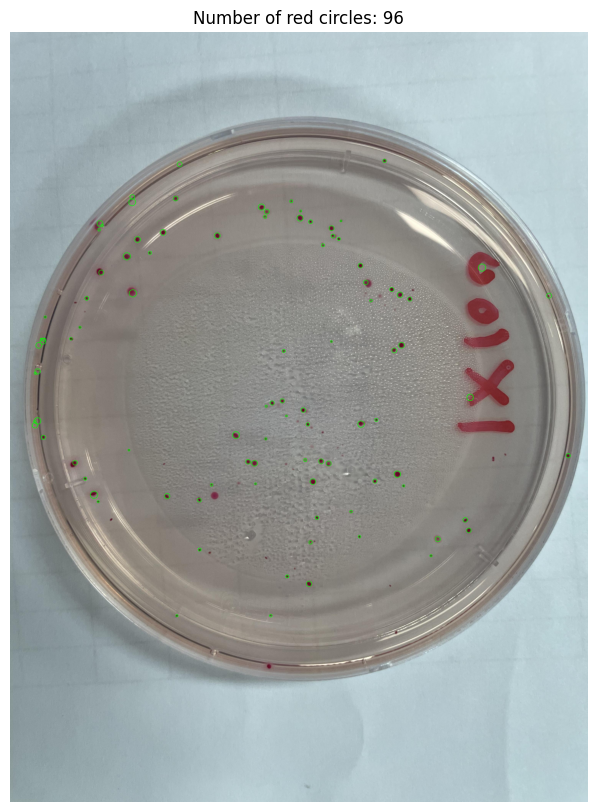

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 학습된 모델 로드
model = load_model('/Users/lol/Documents/GitHub/model/colony_detector_model.h5')
print("Model loaded successfully.")

# 이미지 경로
image_path = '/Users/lol/Documents/GitHub/Python/image/red_colony.jpg'

# 이미지 전처리 및 분할 함수
def preprocess_and_split_image(image_path, tile_size=(256, 256)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at path '{image_path}' could not be loaded. Please check the file path.")
    
    h, w, _ = image.shape
    tiles = []
    
    # 이미지를 tile_size 크기로 분할
    for y in range(0, h, tile_size[1]):
        for x in range(0, w, tile_size[0]):
            tile = image[y:y+tile_size[1], x:x+tile_size[0]]
            if tile.shape[0] != tile_size[1] or tile.shape[1] != tile_size[0]:
                # 패딩을 추가하여 크기를 맞춤
                tile = cv2.copyMakeBorder(tile, 0, tile_size[1] - tile.shape[0], 0, tile_size[0] - tile.shape[1], cv2.BORDER_CONSTANT, value=(0, 0, 0))
            tile_scaled = tile / 255.0
            tiles.append(tile_scaled)
    
    tiles = np.array(tiles)
    grid_shape = (len(range(0, h, tile_size[1])), len(range(0, w, tile_size[0])))
    return tiles, grid_shape, h, w  # h와 w를 반환하여 원본 크기를 유지

# 예측 수행 함수
def predict_colony(image_path, model):
    tiles, grid_shape, h, w = preprocess_and_split_image(image_path)
    predictions = model.predict(tiles)
    return predictions, grid_shape, h, w

# 붉은색 동그라미 콜로니를 카운트하는 함수
def count_red_circles(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at path '{image_path}' could not be loaded. Please check the file path.")

    original_image = image.copy()  # 원본 이미지를 복사하여 저장

    # 이미지를 HSV 색 공간으로 변환
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 붉은색의 범위를 정의 (연한 붉은색 ~ 진한 붉은색)
    lower_red1 = np.array([0, 50, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 50, 50])
    upper_red2 = np.array([180, 255, 255])

    # 붉은색에 해당하는 마스크 생성
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = mask1 | mask2

    # 마스크에 블러 적용
    blurred = cv2.GaussianBlur(mask, (5, 5), 2)

    # 동그라미 검출
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.4, minDist=10,
                               param1=60, param2=22, minRadius=2, maxRadius=50)

    # 동그라미 카운트 및 이미지에 표시
    circle_count = 0
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            if 4 < r < 20:  # 필터링 조건 추가
                cv2.circle(original_image, (x, y), r, (0, 255, 0), 2)  # 원본 이미지에 동그라미 표시
                circle_count += 1

    return circle_count, original_image  # 원본 크기의 이미지를 반환

# 모델을 사용하여 예측 수행
predictions, grid_shape, h, w = predict_colony(image_path, model)

# 예측 결과를 2D 배열로 재구성
predictions_2d = predictions.reshape(grid_shape)

# 전체 이미지에서 예측된 부분을 결합하여 하나의 결과로 통합
overall_prediction = np.mean(predictions_2d)

print(f"Overall Prediction: {overall_prediction}")

# 예측 결과에 따라 붉은색 동그라미 콜로니 카운트 수행
if overall_prediction > 0.6:  # 임계값을 0.6로 설정하여 콜로니가 있는지 확인
    circle_count, output_image = count_red_circles(image_path)
    print(f"Number of red circles detected: {circle_count}")

    # 결과 이미지 시각화
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Number of red circles: {circle_count}")
    plt.axis('off')
    plt.show()
else:
    print("No colonies detected in the image.")